# Predicción de series temporales (Forex)

A lo largo de este notebook, voy a hacer un repaso de los pasos que he ido realizando para implemenar una red neuronal recurrente, basada en células LSTM, para predecir el precio de un par forex, en este caso el par euro-dólar, aunque podría haber sido cualquier otro.

Para ello, he hecho uso de la librería TA-Lib que proporciona diferentes indicadores técnicos como MACD, RSI, CCI, etc...


## 1 Objetivo

El objetivo fundamental del modelo a implementar es conseguir estimar los precios HIGH y LOW de la siguiente sesión, únicamente teniendo en cuenta los precios OHLC y diversos indicadores técnicos aplicados sobre esos precios, durante un número de sesiones anteriores.

Por ejemplo si trabajamos en un timeframe de velas de 1 hora, y utilizamos las últimas 4 velas para predecir la siguiente vela, estaremos utilizando los datos de precio de las últimas 4 horas para predecir cómo evolucionará el precio durante la siguiente hora.

La razón por la que he elegido utilizar las últimas 4 velas es sencilla y no ha sido al azar, la idea es que en tan solo 4 velas, gran parte de los indicadores técnicos como MACD, RSI, etc..., son capaces de generar señales de que algo está ocurriendo en el precio como:

- MACD cruza sobre la línea de cero.
- RSI sale de la zona de sobrecompra.
- Precio sale de las Bandas Bollinger.
- Hay un cruce de medias móviles.
- etc...

Estas señales, en general, indican que el precio está cambiando, ya sea porque una tendencia se está agotando, porque se está entrando en una fase de consolidación o zona lateral, o si se viene de un estancamiento lateral, puede que el precio empiece a romper ese rango para iniciar una nueva tendencia.

La idea de utilizar varios indicadores a la vez, es para intentar extraer patrones repetitivos entre ellos, de forma que si se producen señales sincronizadas en varios de ellos, podremos estimar que la señal es fuerte y que algo puede comenzar a ocurrir en el precio.

Por lo tanto, este modelo, como he dicho, únicamente nos dará idea del valor máximo (HIGH) y mínimo (LOW) que podrá tomar el precio durante la siguiente sesión en curso, es decir, si trabajamos con datos de 1 hora y justo ahora la hora ha cambiado de las 11:59 a las 12:00, en este instante, el modelo predecirá el valor HIGH y LOW hasta las 12:59.

En base a ese rango de variación HIGH-LOW, se podrán realiar operaciones de entrada en largo y corto para aprovechar al máximo ese rango. Pero esto queda fuera del ámbito de este notebook y se abordará más adelante cuando hable del sistema inteligente de inversión basado en Aprendizaje por Refuerzo.

## 2 Preparación

A continuación iré describiendo los pasos que he llevado a cabo para implementar el modelo neuronal comentado.

### Carga de librerías

En primer lugar cargamos las librerías que vamos a utilizar. Las más significativas son:

- Numpy, Pandas, Scikit-Learn, Matplotlib & Seaborn
- Keras como librería ML sobre Tensorflow
- Talib como librería fintech
- MyUtils, una librería propia donde tengo un poco de todo: desde implementaciones neuronales, partición de pares de entrenamiento y test, visualización, backup de archivos en disco, etc...

In [1]:
####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

Using TensorFlow backend.


In [2]:
import MyUtils as utils
print('Ready!')

Ready!


### Obtención del histórico de precios OHLC

Para poder llevar a cabo la implementación del modelo, necesitamos una fuente de datos históricos con los precios OHLC del par euro-dólar.

El siguiente archivo ha sido extraido de Metatrader y en concreto del broker Darwinex. Contiene datos desde el año 2001 hasta el año 2018.

Es importante tener en cuenta lo siguiente a la hora de cargar los datos históricos en el dataframe de trabajo, ya que hay que 'limpiarlos':

- Puesto que trabajamos con datos horarios, hay que reindexar el dataframe de trabajo para que cada registro tenga una cadencia exacta de 1 hora. Esto nos permitirá descubrir todos los datos que falten (NaNs). Por ejemplo, en Forex, no hay cotización durante el fín de semana y por lo tanto todos esos datos están ausentes.
- A parte de las horas en las que no hay cotización, puede darse el caso de que el broker pierda algunos registros, por alguna razón técnica. En ese caso hay que estudiar los datos que faltan y rellenarlos de la mejor forma posible.
- Es necesario también visualizar los datos para verificar que no hay datos erróneos, que alteren la realidad. En caso de que existan, hay que corregirlos.

Para realizar la 'limpieza' anterior, en mi librería 'MyUtils' dispongo de la función 'load_hist' que permite eliminar entradas relativas a fines de semana y hace un relleno de los datos faltantes tipo 'fillna' con la última cotización conocida.


In [3]:
# Cargo el histórico en el dataframe 'df' y visualizo los primeros registros
df = utils.load_hist('EURUSD_H1.csv', sep=';', remove_weekends=True)
df.head()


Deleting weekends...


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2001-01-01 01:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,60,0,5.0,0.0,50.0
2001-01-01 02:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,120,0,5.0,0.0,50.0
2001-01-01 03:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,180,0,5.0,0.0,50.0
2001-01-01 04:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,240,0,5.0,0.0,50.0
2001-01-01 05:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,300,0,5.0,0.0,50.0


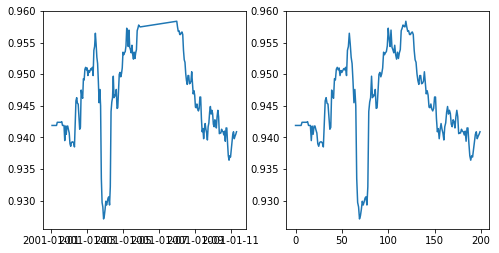

In [4]:
# Visualizo los 200 primeros datos del precio de cierre (CLOSE) de dos formas:
# Utilizando el eje x como fechas espaciadas de hora en hora (se ve un ajuste a mitad de gráfico debido a un fin de semana)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df.CLOSE[0:200])
# Utilizando los datos en bruto, con lo que dicha 'perturbación' ya no queda reflejada y por lo tanto podemos ver que los datos
# son válidos.
plt.subplot(1,2,2)
plt.plot(df.CLOSE.values[0:200])

### Indicadores técnicos

Una vez que tenemos los precios OHLC horarios en el dataframe 'df', voy a integrar en ese mismo dataframe, los indicadores técnicos más representativos de la librería TA-Lib.

Para ello hago uso de la función 'add_indicators' de mi librería de utilidades. Estos son los indicadores técnicos que he utilizado:

- A parte de los precios OHLC he incluido precios medios como OC2 = (O+C/2), HLC3 = (O+H+L/3) y OHLC4 = (O+H+L+C/4), que nos dan idea de relaciones entre ellos.
- BB (BollingerBands) aplicados a los precios H (high) y L (low) y un par de indicadores sintéticos creados a partir de éste, como: BBWidth (anchura de las bandas), BBWSMA4, BBWSMA12 que son las medias móviles de 4 y 12 periodos de la anchura de bandas.
- BB %R, posición del precio en relación a la banda bollinger
- SMA4, SMA16, SMA40, tres medias móviles que de igual forma aplican a los precios H, L.
- MACD (valor, señal e histograma) con la configuración por defecto, sobre H, L.
- RSI (14 periodos) sobre H,L.
- APO (absolute price oscillator)
- MOM (momentum oscillator)
- ROCP,ROCR (rate of change price)
- Williams %R
- ATR y dos medias móviles sobre el ATR: ATR_SMA4, ATR_SMA12
- ADX, ADXR
- CCI
- STOCH (stochastic oscillator)

In [5]:
# Incluyo los indicadores técnicos más representativos y visualizo todas las columnas del nuevo dataframe 'df'
df = utils.add_indicators(df, applied=['HIGH','LOW'], base_cols=['OPEN','HIGH','LOW','CLOSE','OC2','HLC3','OHLC4'])
print(df.columns)
df.head(1)

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'OC2', 'HLC3', 'OHLC4',
       'IND_BB_UPPER_HIGH', 'IND_BB_MIDDLE_HIGH', 'IND_BB_LOWER_HIGH',
       'IND_BB_WIDTH_HIGH', 'IND_BB_PERCENT_HIGH', 'IND_BB_WIDTH_SMA4_HIGH',
       'IND_BB_WIDTH_SMA12_HIGH', 'IND_SMA4_HIGH', 'IND_SMA16_HIGH',
       'IND_SMA40_HIGH', 'IND_MACD_HIGH', 'IND_MACD_SIG_HIGH',
       'IND_MACD_HIST_HIGH', 'IND_RSI_HIGH', 'IND_APO_HIGH', 'IND_MOM_HIGH',
       'IND_ROCP_HIGH', 'IND_ROCR_HIGH', 'IND_BB_UPPER_LOW',
       'IND_BB_MIDDLE_LOW', 'IND_BB_LOWER_LOW', 'IND_BB_WIDTH_LOW',
       'IND_BB_PERCENT_LOW', 'IND_BB_WIDTH_SMA4_LOW', 'IND_BB_WIDTH_SMA12_LOW',
       'IND_SMA4_LOW', 'IND_SMA16_LOW', 'IND_SMA40_LOW', 'IND_MACD_LOW',
       'IND_MACD_SIG_LOW', 'IND_MACD_HIST_LOW', 'IND_RSI_LOW', 'IND_APO_LOW',
       'IND_MOM_LOW', 'IND_ROCP_LOW', 'IND_ROCR_LOW', 'IND_WILLR', 'IND_ATR',
       'IND_ATR_SMA4', 'IND_ATR_SMA12', 'IND_ADX', 'IND_ADXR', 'IND_CCI',
       'IND_SLOWK', 'IND_SLOWD'],
      dtype='object')


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ROCR_LOW,IND_WILLR,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD
2001-01-02 17:00:00,0.9474,0.9479,0.9451,0.9466,0.947,0.946533,0.94675,0.949573,0.94322,0.936867,...,1.007892,-20.535714,0.002487,0.002248,0.001847,26.239061,29.470872,93.474427,66.333333,44.572378


### Preparación de las salidas a predecir

Como ya he comentado, el modelo predecirá el valor estimado del precio HIGH,LOW para la siguiente sesión, en este caso, no se predecirá el precio que obtendrá H,L sino que se estimará cuánto variará H,L respecto del valor de cierre actual.

Para entenderlo mejor, supongamos la situación actual:

- En la sesión actual el precio de cierre es: close = 1.0050
- En los datos de entrenamiento, vemos que el precio HIGH de la siguiente sesión es: high = 1.0092

Por lo tanto, la salida objetivo para el precio HIGH será: **out_high** = high(t+1) - close(t) = 1.0092 - 1.0050 = **0.0042**.

Y de igual forma para el precio LOW: **out_low** = low(t+1) - close(t).

In [9]:
# función para generar las salidas a predecir
def define_outputs(df):  
  df['OUT_HIGH'] = df.HIGH - df.CLOSE.shift(1)
  df['OUT_LOW'] = df.LOW - df.CLOSE.shift(1)
  return df

# Añado las salidas a predecir al dataframe 'df'
df = define_outputs(df)
df.dropna(inplace=True)
df.head()

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD,OUT_HIGH,OUT_LOW
2001-01-02 19:00:00,0.9464,0.9496,0.9455,0.9493,0.94785,0.948133,0.947700,0.951093,0.943875,0.936657,...,0.002630,0.002524,0.002076,26.008614,29.244717,110.866255,82.398754,75.799585,0.0034,-0.0007
2001-01-02 20:00:00,0.9493,0.9503,0.9482,0.9491,0.94920,0.949200,0.949225,0.951967,0.944295,0.936623,...,0.002592,0.002557,0.002167,26.273106,29.692141,129.569424,85.669816,82.245079,0.0010,-0.0011
2001-01-02 21:00:00,0.9489,0.9517,0.9486,0.9508,0.94985,0.950367,0.950000,0.953012,0.944790,0.936568,...,0.002628,0.002592,0.002236,26.912704,29.079180,154.054054,90.124362,86.064311,0.0026,-0.0005
2001-01-02 22:00:00,0.9506,0.9512,0.9492,0.9511,0.95085,0.950500,0.950525,0.953613,0.945405,0.937197,...,0.002584,0.002609,0.002297,27.506617,29.441555,137.467118,87.833135,87.875771,0.0004,-0.0016
2001-01-02 23:00:00,0.9510,0.9519,0.9506,0.9507,0.95085,0.951067,0.951050,0.954218,0.946030,0.937842,...,0.002492,0.002574,0.002349,28.259486,30.011312,126.970753,85.978739,87.978745,0.0008,-0.0005


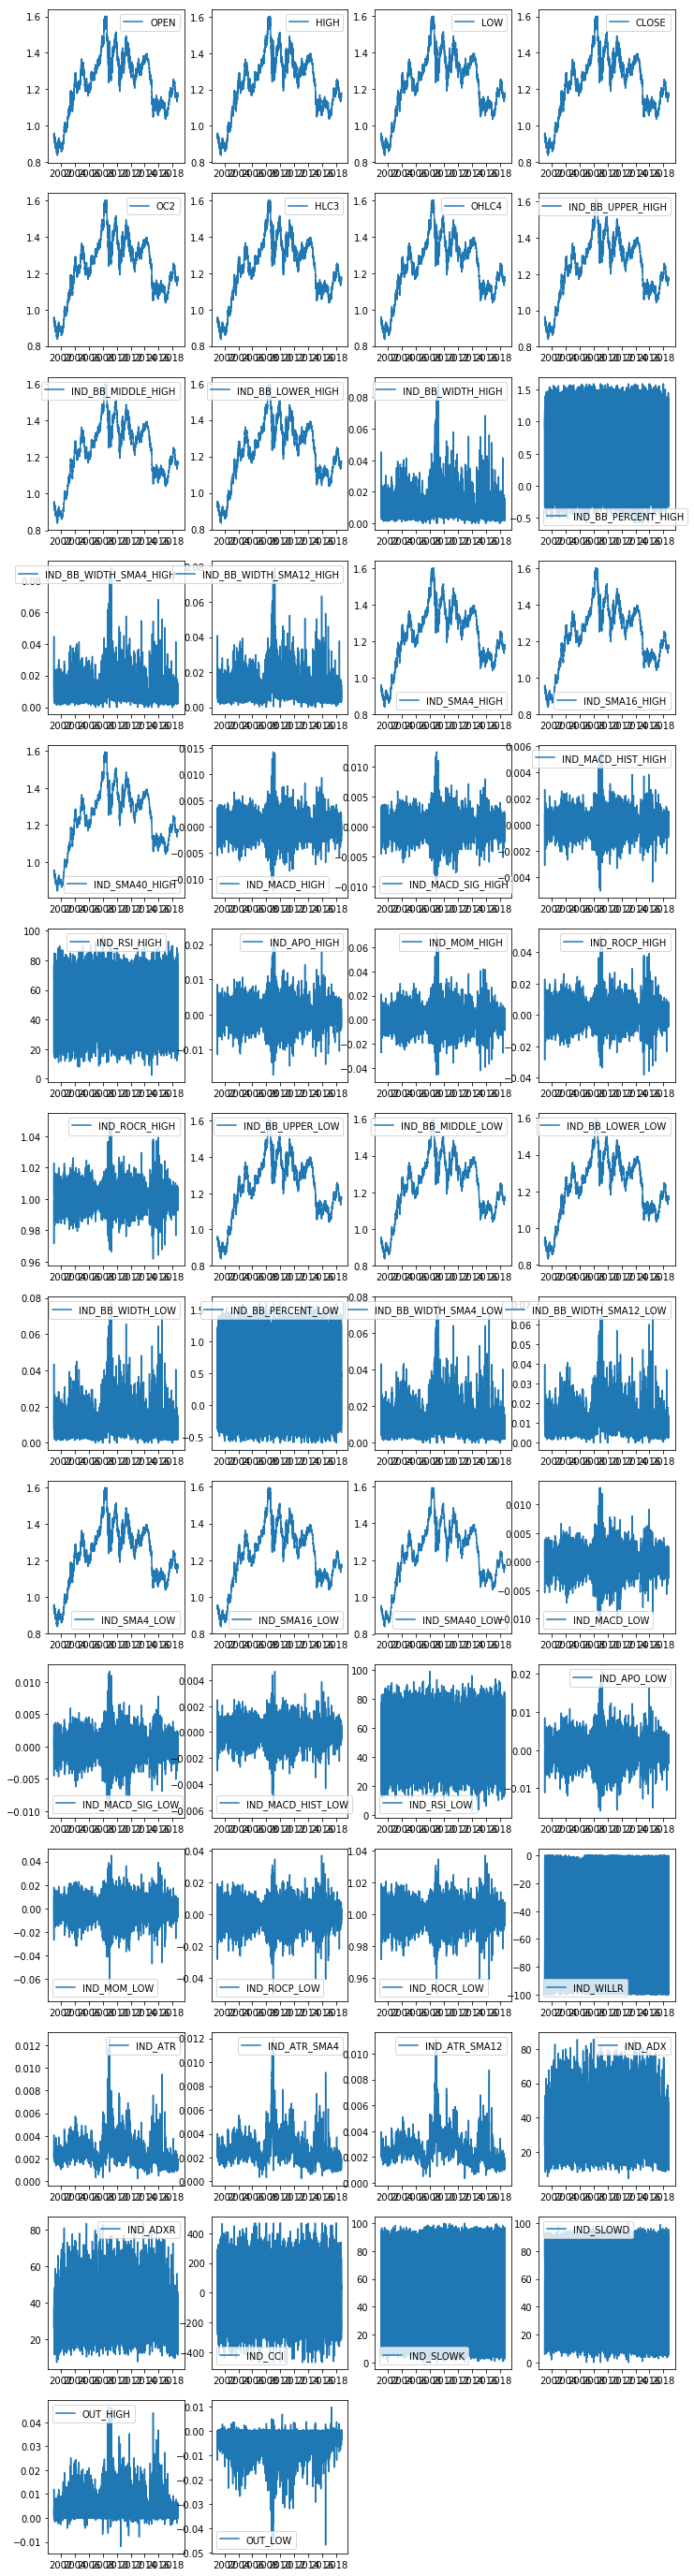

In [10]:
# Visualizo gráficamente todos los 'features' que forman el dataframe 'df', incluyendo las salidas a predecir
rows = (df.shape[1] / 4) + 1
plt.figure(figsize = (12,50))
for c in df.columns:
  i = df.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df[c])
  plt.legend([c])
  

### Adaptación de los datos al modelo neuronal

Puesto que el modelo neuronal que planteo utiliza datos relativos a las últimas 4 velas para predecir lo que hará el precio en la siguiente vela, es necesario adaptar todos los 'features' de entrada del dataframe 'df' de forma que obtengamos los valores de cada timestep. Así para 4 velas previas necesitaremos los datos en: (t-3), (t-2), (t-1) y (t).

Y de igual forma para las salidas a predecir, necesitaremos los datos en (t+1).

Para realizar dicha adaptación utilizo mi librería de utilidades con la función 'series_to_supervised', que además de realizar dicha adaptación, 'limpia' el dataframe resultante 'df_nn' eliminando los datos (NaNs) generados a la hora de obtener datos del futuro que aún no existen en los últimos registros.

In [11]:
# Defino el formato del dataframe 'df_nn' que voy a obtener como proceso de adaptación. Es necesario definir las siguientes
# variables que se utilizarán a lo largo del desarrollo

# Número de salidas a predecir
num_outputs = 2

# Número de 'features' de entrada
num_inputs = len(df.columns) - num_outputs

# Número de timesteps previos
n_in = 4

# Número de timesteps a futuro
n_out = 1

# Flag para eliminar NaNs del dataframe resultante tras aplicar la adaptación
dropnan = True

# Procesa la adaptación al dataframe 'df' y genera un nuevo dataframe 'df_nn'
df_nn = utils.series_to_supervised(df, num_inputs, num_outputs, n_in, n_out, dropnan)
print(df_nn.shape)
df_nn.head()

(111074, 210)


,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2001-01-02 22:00:00,0.9464,0.9496,0.9455,0.9493,0.94785,0.948133,0.947700,0.951093,0.943875,0.936657,...,0.002584,0.002609,0.002297,27.506617,29.441555,137.467118,87.833135,87.875771,0.0008,-0.0005
2001-01-02 23:00:00,0.9493,0.9503,0.9482,0.9491,0.94920,0.949200,0.949225,0.951967,0.944295,0.936623,...,0.002492,0.002574,0.002349,28.259486,30.011312,126.970753,85.978739,87.978745,0.0007,-0.0001
2001-01-03 00:00:00,0.9489,0.9517,0.9486,0.9508,0.94985,0.950367,0.950000,0.953012,0.944790,0.936568,...,0.002371,0.002519,0.002392,28.958579,30.156251,101.740020,82.416085,85.409320,0.0003,-0.0017
2001-01-03 01:00:00,0.9506,0.9512,0.9492,0.9511,0.95085,0.950500,0.950525,0.953613,0.945405,0.937197,...,0.002345,0.002448,0.002429,28.762562,29.868250,68.501003,64.429771,77.608198,0.0014,-0.0002
2001-01-03 02:00:00,0.9510,0.9519,0.9506,0.9507,0.95085,0.951067,0.951050,0.954218,0.946030,0.937842,...,0.002291,0.002375,0.002455,28.580546,28.996690,66.819720,54.630388,67.158748,0.0009,-0.0009


In [12]:
# chequeo que la generación de las salidas a predecir es correcta mediante un dataframe temporal '_df' con las columnas más
# representativas. Verificaré que la columna 'next_high' coincide con 'HIGH(t)' desplazada 1 sesión en el futuro
_df = df_nn[['HIGH(t-1)','HIGH(t)','LOW(t-1)','LOW(t)','CLOSE(t-1)', 'CLOSE(t)','OUT_HIGH(t+1)']].head(10).copy()
_df['next_high'] = _df['CLOSE(t)']+ _df['OUT_HIGH(t+1)']
_df

,HIGH(t-1),HIGH(t),LOW(t-1),LOW(t),CLOSE(t-1),CLOSE(t),OUT_HIGH(t+1),next_high
2001-01-02 22:00:00,0.9517,0.9512,0.9486,0.9492,0.9508,0.9511,0.0008,0.9519
2001-01-02 23:00:00,0.9512,0.9519,0.9492,0.9506,0.9511,0.9507,0.0007,0.9514
2001-01-03 00:00:00,0.9519,0.9514,0.9506,0.9506,0.9507,0.9510,0.0003,0.9513
2001-01-03 01:00:00,0.9514,0.9513,0.9506,0.9493,0.9510,0.9498,0.0014,0.9512
2001-01-03 02:00:00,0.9513,0.9512,0.9493,0.9496,0.9498,0.9506,0.0009,0.9515
2001-01-03 03:00:00,0.9512,0.9515,0.9496,0.9497,0.9506,0.9503,0.0012,0.9515
2001-01-03 04:00:00,0.9515,0.9515,0.9497,0.9499,0.9503,0.9506,0.0005,0.9511
2001-01-03 05:00:00,0.9515,0.9511,0.9499,0.9504,0.9506,0.9509,0.0003,0.9512
2001-01-03 06:00:00,0.9511,0.9512,0.9504,0.9502,0.9509,0.9507,0.0011,0.9518
2001-01-03 07:00:00,0.9512,0.9518,0.9502,0.9502,0.9507,0.9511,0.0001,0.9512


### Normalización de los datos

A la hora de utilizar los datos como entrada del modelo neuronal, es necesario que todos estén en el mismo factor de escala o que tengan valores en un rango similar, de forma que facilite el entrenamiento del modelo.

Para ello utilizo la librería 'sklearn' con el scaler 'MinMaxScaler' que permite reajustar diferentes conjuntos de datos de una sola vez.

El 'scaler' resultante deberé guardarlo para reutilizarlo en el proceso inverso de de-normalización, para obtener los valores reales predichos.

In [13]:
#### Normalización de los datos sobre el datafram 'df_nn'. Genero un nuevo dataframe 'dfnorm'
dfnorm, scaler = utils.normalize_data(df_nn)
# Verifico los datos del nuevo dataframe generado
dfnorm.describe()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
count,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,...,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000,111074.000000
mean,0.033872,0.033238,0.035224,0.033870,0.034966,0.035161,0.035244,0.038393,0.037114,0.033327,...,-0.623475,-0.606744,-0.589015,-0.241415,-0.260164,0.002242,0.001102,0.001112,-0.548019,0.615988
std,0.417061,0.416512,0.417313,0.416949,0.417600,0.417512,0.417561,0.419485,0.419824,0.416747,...,0.169776,0.177402,0.189264,0.344249,0.329897,0.237713,0.460990,0.426409,0.062081,0.063146
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.239546,-0.239932,-0.237955,-0.239483,-0.238786,-0.238527,-0.238473,-0.235434,-0.238731,-0.240257,...,-0.738342,-0.727206,-0.717671,-0.505740,-0.508428,-0.171890,-0.378993,-0.344842,-0.578315,0.607300
50%,0.091015,0.090056,0.092349,0.091004,0.092160,0.092404,0.092445,0.096931,0.095170,0.089241,...,-0.648405,-0.632093,-0.615074,-0.296451,-0.311956,0.004566,0.006301,0.006716,-0.564591,0.633269
75%,0.324540,0.322944,0.326707,0.324455,0.326141,0.326154,0.326316,0.327143,0.329469,0.324917,...,-0.549768,-0.529223,-0.506305,-0.026225,-0.057785,0.176272,0.381170,0.348111,-0.540573,0.647658
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3 Construcción del modelo neuronal

En primer lugar, como ya dije, voy a utilizar Keras como frontend sobre Tensorflow para construir una red neuronal recurrente basada en células LSTM.

Para realizar la implementación de la red utilizaré mi librería de utilidades con la función 'buil_lstm_net' que crea una red del tipo anterior con una serie de características ajustables como argumentos: número de entradas, salidas, timesteps hacia atrás y hacia adelante, número de capas, etc...

En primer lugar para verificar que el modelo es decente, realizaré una validación cruzada utilizando la librería 'sklearn' con la función 'Kfolds'.

Generaré 5 modelos diferentes con distintos conjuntos de entrenamiento y validación para obtener un 'score' medio del modelo que he seleccionado.

Si el modelo genera un 'score' decente, entrenaré el modelo para generar los pesos de la red neuronal que posteriormente guardaré en un archivo con formato HDF5.

Por lo tanto, resumiendo, los pasos a seguir son:

- Realizar una validación cruzada con el modelo seleccionado.
- Verificar si el 'score' medio es bueno y en ese caso, entrenar dicho modelo
- Verificar si el modelo se comporta bien con datos que nunca ha visto anteriormente
- Guardar los pesos de la red en un archivo HDF5

### Validación cruzada

Utilizaré el dataframe normalizado 'dfnorm' para dividirlo en pares de entrada-salida (X,Y). Generaré 5 conjuntos con sendos modelos neuronales formados por:

- 3 capas LSTM con 64 neuronas por capa.
- 1 capa Dense intermedia con 128 neuronas.
- 1 capa Dense de salida con 2 neuronas (una por salida)

In [14]:
# split into input (X) and output (Y) variables
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
# define 5-fold cross validation test harness
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
i=0
for train, test in kfold.split(X, Y):
  # create model
  model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'weights_2711_m'+str(i)+'.hd5')
  i += 1
  # Fit the model
  x = X[train]
  x = x.reshape(x.shape[0], n_in, num_inputs)
  utils.fit(model, x, Y[train], num_inputs, n_in, num_epochs=5, callbacks=callbacks, batchsize=32)  
  # evaluate the model
  x = X[test]
  scores = utils.test_evaluation(model, x, Y[test], num_inputs, n_in)
  x = x.reshape(x.shape[0], n_in, num_inputs)
  scores = model.evaluate(x, Y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

No weights file to load
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             29952     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 64)             33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)            

C:\Users\raulm\Programas\anaconda3\envs\keras\lib\site-packages\keras\callbacks.py:434: RuntimeWarning:

Can save best model only with val_acc available, skipping.



 - 15s - loss: 0.0038 - acc: 0.9997
Epoch 3/5
 - 15s - loss: 0.0038 - acc: 0.9997
Epoch 4/5
 - 15s - loss: 0.0037 - acc: 0.9997
Epoch 5/5
 - 15s - loss: 0.0037 - acc: 0.9997
loss: 0.44%
acc: 99.99%
No weights file to load
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 64)             29952     
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 64)             33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
____________________________________________________

Puesto que el modelo parece arrojar buenos resultados, voy a pasar a la fase de entrenamiento final de dicho modelo.

### Entrenamiento del modelo

Para realizar el entrenamiento del modelo, dividiré el dataframe 'dfnorm' en dos grupos: el de entrenamiento con el 80% de los datos y el de test con el 20% restante.

Crearé el modelo neuronal anterior y tras su entrenamiento verificaré los resultados

In [15]:
# Preparo los conjuntos de entrenamiento y validación en una proporción del 80-20
x_train,y_train,x_test,y_test = utils.prepare_training_data(dfnorm, num_inputs * n_in, 0.8)
print('x_train:', x_train.shape, 'y_train', y_train.shape)
print('x_test:', x_test.shape, 'y_test', y_test.shape)


x_train: (88859, 208) y_train (88859, 2)
x_test: (22215, 208) y_test (22215, 2)


In [16]:
# Creo el mismo modelo neuronal utilizado durante la validación  cruzada
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'weights_3.2.64.128.hd5')

No weights file to load
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 4, 64)             29952     
_________________________________________________________________
dropout_16 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 4, 64)             33024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)            

Train on 71087 samples, validate on 17772 samples
Epoch 1/10
 - 16s - loss: 0.0058 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 2/10
 - 13s - loss: 0.0044 - acc: 0.9997 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3/10
 - 14s - loss: 0.0044 - acc: 0.9997 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 4/10
 - 13s - loss: 0.0044 - acc: 0.9997 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 5/10
 - 13s - loss: 0.0044 - acc: 0.9997 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 6/10
 - 14s - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 7/10
 - 14s - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 8/10
 - 14s - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 9/10
 - 14s - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 10/10
 - 14s - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0027 - val_acc: 1.0000


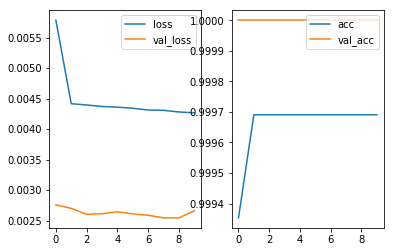

In [17]:
# Realizo el proceso de entrenamiento durante un número de épocas.
num_epochs = 10
# Tamaño del batch para la actualización de pesos
batchsize = 32
# Utilizo un 20% de los datos para realizar una validación
val_ratio = 0.2
# Cojo datos de forma aleatoria durante la fase de entrenamiento
shuffle = True
# Flag para visualizar los resultados al final del proceso
plot_results = True
# Función para iniciar el entrenamiento
result = utils.fit(model, x_train, y_train, num_inputs, n_in, num_epochs, callbacks, batchsize, val_ratio, shuffle, plot_results)

In [18]:
# Guardo los pesos en un archivo HDF5
model.save_weights('weights_3.2.64.128.hd5')

### Verificación del modelo

Una vez que he entrenado el modelo, voy a verificar cómo se comportaría con datos que nunca ha visto previamente, para ello utilizo el subconjunto de test con mi librería de utilidades y la función 'test_rmse'.

Esta función, evalúa cada para X,Y de test y utiliza una callback 'out_builder' y el 'scaler' utilizado durante la normalización, para deshacer el escalado en los datos predichos y calcular cuál sería el valor real predicho de los precios HIGH,LOW y comparalos con los precios objetivo.

A partir de esas diferencias, se obtendrá el error RMSE para todo el conjunto de test.

Model Loss:  0.002455687627973943
Model Accuracy:  0.9997749268512266


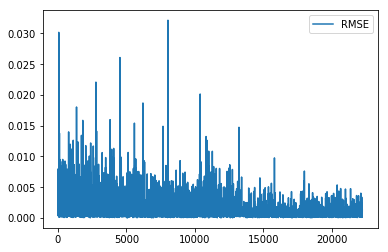

In [19]:
# Evaluación del modelo con la partición de test. Utilizo callback para formar las salidas reales
ih = df_nn.columns.get_loc('OUT_HIGH(t+1)')  
il = df_nn.columns.get_loc('OUT_LOW(t+1)')
ic = df_nn.columns.get_loc('CLOSE(t)')
  
def out_builder(xy,xyhat):
  return np.asarray([xy[ih]+xy[ic],xy[il]+xy[ic]]), np.asarray([xyhat[ih]+xyhat[ic],xyhat[il]+xyhat[ic]])
  
scores, targets, preds, rmse = utils.test_rmse(model, x_test, y_test, num_inputs, n_in, num_outputs, n_out, scaler, out_builder, True)

In [20]:
# obtengo los resultados como arrays
atgt = np.asarray(targets)
apreds = np.asarray(preds)
armse = np.asarray(rmse)

# creo un nuevo dataframe de resultados 'df_predict'
df_predict = df_nn[x_train.shape[0]:].copy()
#... al que añado las predicciones hechas...
df_predict['PREDICT_HIGH'] = apreds[:,0]
df_predict['PREDICT_LOW'] = apreds[:,1]

#... los objetivos que debería haber predicho...
df_predict['TARGET_HIGH'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)'] 

#... unas columnas para chequear que los objetivos son correctos
df_predict['TARGET_HIGH_CHECK'] = atgt[:,0]
df_predict['TARGET_LOW_CHECK'] = atgt[:,1]

#... el error RMSE
df_predict['RMSE'] = armse[:]

df_predict.head()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1),PREDICT_HIGH,PREDICT_LOW,TARGET_HIGH,TARGET_LOW,TARGET_HIGH_CHECK,TARGET_LOW_CHECK,RMSE
2015-03-13 09:00:00,1.06137,1.06138,1.06009,1.06040,1.060885,1.060623,1.060810,1.066305,1.062948,1.059591,...,28.416810,0.00234,-0.00081,1.062329,1.058200,1.06343,1.06028,1.06343,1.06028,0.001664
2015-03-13 10:00:00,1.06039,1.06061,1.05960,1.06001,1.060200,1.060073,1.060153,1.066328,1.062933,1.059538,...,42.222676,-0.00001,-0.00266,1.062905,1.059226,1.06183,1.05918,1.06183,1.05918,0.000761
2015-03-13 11:00:00,1.05999,1.05999,1.05644,1.05788,1.058935,1.058103,1.058575,1.066444,1.062833,1.059221,...,60.998242,0.00042,-0.00294,1.061802,1.058376,1.06123,1.05787,1.06123,1.05787,0.000540
2015-03-13 12:00:00,1.05787,1.06169,1.05716,1.06109,1.059480,1.059980,1.059452,1.066261,1.062695,1.059129,...,64.600223,0.00096,-0.00189,1.059135,1.055737,1.05912,1.05627,1.05912,1.05627,0.000377
2015-03-13 13:00:00,1.06112,1.06343,1.06028,1.06184,1.061480,1.061850,1.061667,1.064946,1.062450,1.059954,...,53.732409,0.00315,-0.00013,1.057727,1.054256,1.05983,1.05655,1.05983,1.05655,0.002200


Con el nuevo dataframe de resultado 'df_predict', realizo una visualización para ver cómo se ha comportado el modelo.

Visualizaré un rango de datos (i:j) de los objetivos H,L buscados y las predicciones reales generadas. El área entre los objetivos H-L se rellenerá en color gris, mientras que el área de las predicciones se rellenará en amarillo.

De esta forma, se puede ver claramente, si el rango de predicción es correcto y está alineado con el objetivo.

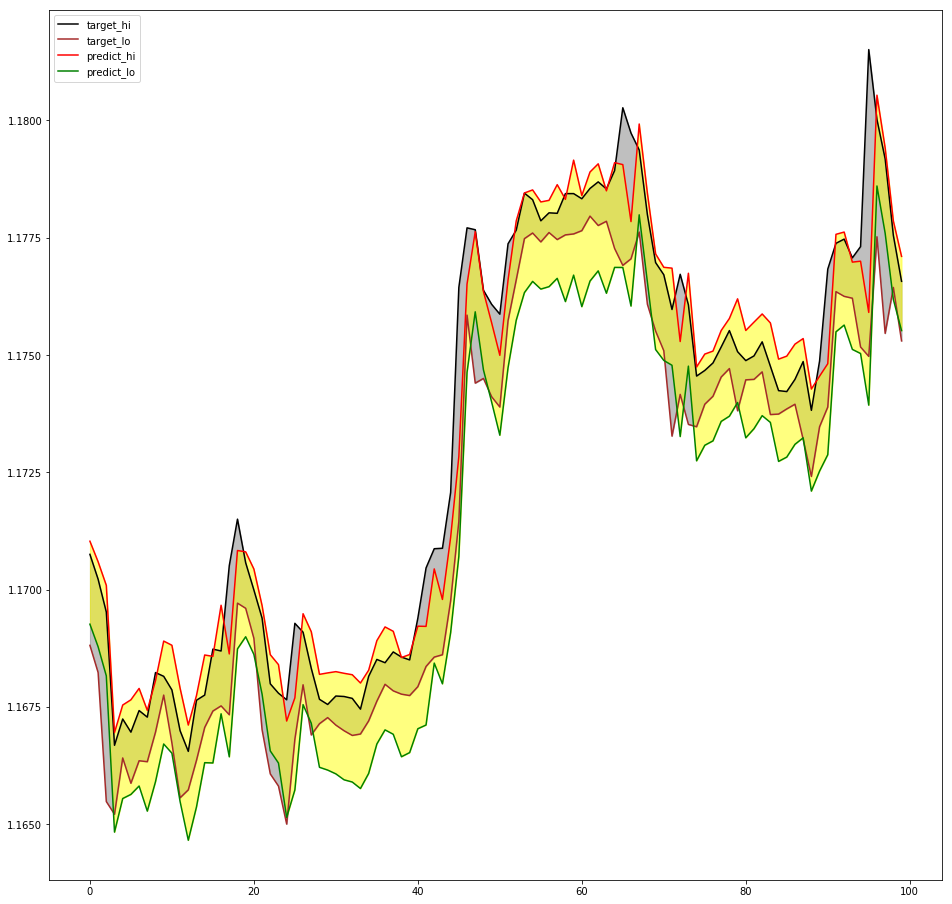

In [46]:
plt.figure(figsize=(16,16))
i,j=-200,-100
x = np.arange(j-i)
y1 = df_predict['TARGET_HIGH'].values[i:j]
y2 = df_predict['TARGET_LOW'].values[i:j]
y3 = df_predict['PREDICT_HIGH'].values[i:j]
y4 = df_predict['PREDICT_LOW'].values[i:j]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])


## 4 Conclusiones


Como puede observarse, el rango de predicción suele contener al rango objetivo en la gran mayoría de casos. Sólo presenta errores de predicción cuando se producen picos abruptos en los valores HIGH,LOW objetivos.

En este punto, el modelo se podría utilizar como punto de entrada para un Agente inteligente, que utilizara estas predicciones y el precio en tiempo real para realiar operaciones de entrada-salida en dicho par.

Por otro lado, con los datos obtenidos en el dataframe 'df_predict' se podría estudiar qué entradas están más correlacionadas con las salidas, por qué se producen esos picos que el modelo no es capaz de identificar, etc...

In [24]:
# Hago una copia para estudiar los resultados más en detalle
df_st = df_predict.copy()
df_st.corr().sort_values('PREDICT_HIGH', ascending=False)

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1),PREDICT_HIGH,PREDICT_LOW,TARGET_HIGH,TARGET_LOW,TARGET_HIGH_CHECK,TARGET_LOW_CHECK,RMSE
PREDICT_HIGH,0.998606,0.998578,0.998615,0.998933,0.998853,0.998890,0.998857,0.995699,0.996920,0.994731,...,0.058483,-0.090171,0.055606,1.000000,0.999946,0.999574,0.999575,0.999574,0.999575,-0.103704
CLOSE(t),0.998622,0.998580,0.998637,0.998956,0.998872,0.998906,0.998872,0.995522,0.996927,0.994919,...,0.059222,-0.091651,0.056574,0.999976,0.999983,0.999553,0.999625,0.999553,0.999625,-0.105082
PREDICT_LOW,0.998610,0.998566,0.998628,0.998938,0.998857,0.998892,0.998859,0.995403,0.996893,0.994969,...,0.058489,-0.092033,0.057684,0.999946,1.000000,0.999524,0.999638,0.999524,0.999638,-0.106055
HLC3(t),0.998746,0.998703,0.998759,0.999086,0.998999,0.999031,0.998997,0.995617,0.997033,0.995034,...,0.058791,-0.091668,0.056609,0.999901,0.999909,0.999477,0.999552,0.999477,0.999552,-0.105148
OC2(t),0.998871,0.998822,0.998881,0.999210,0.999123,0.999152,0.999119,0.995725,0.997158,0.995177,...,0.058609,-0.092042,0.056416,0.999890,0.999897,0.999458,0.999538,0.999458,0.999538,-0.105252
OHLC4(t),0.998835,0.998789,0.998847,0.999176,0.999089,0.999119,0.999085,0.995691,0.997118,0.995130,...,0.058592,-0.091859,0.056521,0.999873,0.999881,0.999445,0.999522,0.999445,0.999522,-0.105216
OPEN(t),0.998953,0.998896,0.998958,0.999297,0.999209,0.999232,0.999200,0.995761,0.997222,0.995268,...,0.057986,-0.092417,0.056249,0.999637,0.999644,0.999196,0.999284,0.999196,0.999284,-0.105404
CLOSE(t-1),0.998965,0.998908,0.998969,0.999308,0.999220,0.999243,0.999211,0.995783,0.997240,0.995282,...,0.058018,-0.092287,0.056264,0.999627,0.999633,0.999189,0.999274,0.999189,0.999274,-0.105293
LOW(t),0.998588,0.998498,0.998645,0.998925,0.998840,0.998871,0.998838,0.995270,0.996866,0.995045,...,0.058435,-0.093751,0.058637,0.999597,0.999649,0.999138,0.999332,0.999138,0.999332,-0.106564
HIGH(t),0.998483,0.998484,0.998452,0.998832,0.998741,0.998771,0.998736,0.995517,0.996761,0.994595,...,0.058685,-0.089543,0.054575,0.999584,0.999551,0.999196,0.999152,0.999196,0.999152,-0.103735


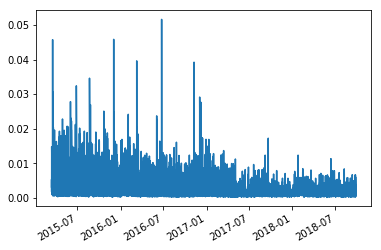

In [40]:
# evalúo los picos donde falla la predicción
(df_st['TARGET_HIGH'] - df_st['TARGET_LOW']).plot()

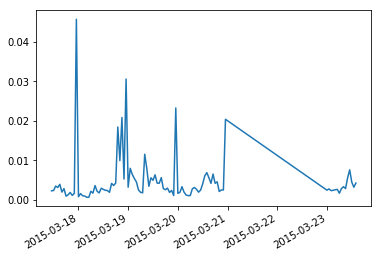

In [39]:
# evalúo los picos donde falla la predicción
(df_st['TARGET_HIGH'] - df_st['TARGET_LOW'])[50:150].plot()



Como se observa en el gráfico anterior, y si se hacen más pruebas, se confirma, los picos suceden prácticamente a diario a las 23:00. Este hecho ha desaparecido recientemente y deja de apreciarse desde el 2017.

Vamos a ver si ocurría antes incluso del 2015.

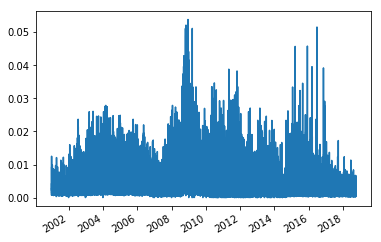

In [45]:
# evalúo los picos donde falla la predicción
(df['HIGH'] - df['LOW']).plot()